In [ ]:
# You need to install the python Weaviate client
!pip install weaviate-client

## Download data
Download data from [drive](https://drive.google.com/file/d/1W8nBPZA2j1_6AGnw2BAe6ydXLNXzuDq2/view?usp=share_link)

In [1]:
import weaviate

print(weaviate.__version__)

3.15.4


## Configure the Weaviate Cloud Instance
### Free 14 day sandbox here: https://console.weaviate.cloud/

In [43]:
import os
import weaviate
from wcs_key import wcs_token

auth_config = weaviate.auth.AuthApiKey(api_key=wcs_token)  # Replace w/ your API Key for the Weaviate instance

client = weaviate.Client(
    url="https://deep-hackathon-demo-krewbk5v.weaviate.network",
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),   # Replace w/ your Cohere Key 
        "X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY"),   # Replace w/ your OpenAI Key 
    }
)
client.is_ready()

True

In [3]:
weaviate.__version__

'3.15.4'

## Create Database Schema

In [4]:
# delete existing schema, (note, this will delete all your weaviate data)
#client.schema.delete_all()

article_schema = {
    "class": "Article",
    "description": "Wiki Article",
    "vectorizer": "text2vec-cohere",#multi-lingual
    "moduleConfig": {
        "text2vec-cohere": {
            "model": "multilingual-22-12",
            "truncate": "RIGHT"
        }
    },
    "vectorIndexConfig": {
        "distance": "dot"
    },
    "properties": [
    {
        "name": "text",
        "dataType": [ "text" ],
        "description": "Article body",
        "moduleConfig": {
            "text2vec-cohere": {
                "skip": False,
                "vectorizePropertyName": False
            }
        }
    },
    {
        "name": "title",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "url",
        "dataType": [ "string" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "wiki_id",
        "dataType": [ "int" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    {
        "name": "views",
        "dataType": [ "number" ],
        "moduleConfig": { "text2vec-cohere": { "skip": True } }
    },
    ]
}

# add the schema
client.schema.create_class(article_schema)

print("The schema has been created")

The schema has been created


In [5]:
import pandas as pd
df = pd.read_parquet('wiki_simple_100k.parquet')

In [6]:
df.head()

,id,title,text,url,wiki_id,views,paragraph_id,langs,emb
0,0,24-hour clock,The 24-hour clock is a way of telling the time...,https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,0,30,"[0.07711287587881088, 0.3197174072265625, -0.2..."
1,1,24-hour clock,A time in the 24-hour clock is written in the ...,https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,1,30,"[0.19612890481948853, 0.5142669677734375, 0.03..."
2,2,24-hour clock,"However, the US military prefers not to say 24...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,2,30,"[0.1391918957233429, 0.17759686708450317, -0.1..."
3,3,24-hour clock,"24-hour clock time is used in computers, milit...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,3,30,"[0.1279686838388443, 0.06708071380853653, -0.0..."
4,4,24-hour clock,"In railway timetables 24:00 means the ""end"" of...",https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,4,30,"[0.0753360167145729, 0.3530837893486023, -0.08..."


## Batch and Add 100k Wikipedia Articles to Weaviate

In [8]:
### Step 1 - configure Weaviate Batch, which optimizes CRUD operations in bulk
# - starting batch size of 100
# - dynamically increase/decrease based on performance
# - add timeout retries if something goes wrong

client.batch.configure(
    batch_size=100,
    dynamic=True,
    timeout_retries=3,
)

In [9]:
data = df[:100_000] # make sure it is not more than 100k objects

counter=0

with client.batch as batch:
    for idx, item in data.iterrows():        
        # print update message every 100 objects        
        if (counter %100 == 0):
            print(f"Import {counter} / {len(data)} ", end="\r")

        properties = {
        "text": item["text"],
        "title": item["title"],
        "url": item["url"],
        "views": item["views"],
        "wiki_id": item["wiki_id"]
        }

        vector = item["emb"]

        batch.add_data_object(properties, "Article", None, vector)
        counter = counter+1
    print(f"Import {counter} / {len(data)}")
        
print("Import complete")

Import 100000 / 100000
Import complete


In [10]:
# Test that all data has loaded – get object count
result = (
    client.query.aggregate("Article")
    .with_fields("meta { count }")
    .do()
)
print("Object count: ", result["data"]["Aggregate"]["Article"])

Object count:  [{'meta': {'count': 100000}}]


In [11]:
def semantic_search(query):
    nearText = {
        "concepts": [query],
#         "distance": -139.0,
    }

    properties = [
        "text", "title", "url", "views",
        "_additional {distance}"
    ]

    response = (
        client.query
        .get("Article", properties)
        .with_near_text(nearText)
        .with_limit(5)
        .do()
    )

    result = response['data']['Get']['Article']

    return result
    
def print_result(result):
    for item in result:
        print(f"\033[95m{item['title']} ({item['views']}) {item['_additional']['distance']}\033[0m")
        print(f"\033[4m{item['url']}\033[0m")
        print(item['text'])
        print()

## Search through your data
1. Vector Search
2. Classic Word Search
3. Hybrid Search
4. Generative Search

In [77]:
where_filter = {
  "path": ["title"],
  "operator": "Like", #
  "valueString": "Avocado"
}

query_result = (
  client.query
  .get("Article", ["title", "text"])
  .with_where(where_filter)
  .do()
)

print(query_result['data']['Get']['Article'][0]['text'])

The term avocado refers to a type of berry. It has medium dark green or dark green bumpy or smooth skin depending on the variety. The flesh of an avocado is deep chartreuse green in color near the skin and pale chartreuse green near the core. It has a creamy, rich texture. The word, Avocado came from a aztec word meaning testicle. Avocado trees come from Central America and Mexico. They can grow in many places, as long as it is not too cold.


In [78]:
query_result = semantic_search("a programming language used for machine learning")

print_result(query_result)

Python (programming language) (398.0628356933594) -147.34064
https://simple.wikipedia.org/wiki?curid=44678
Python has become one of the most famous programming languages on the world as of late. It's utilized in all that from AI to building sites and programming testing. It tends to be utilized by engineers and non-designers the same.

C++ (194.4631805419922) -146.67387
https://simple.wikipedia.org/wiki?curid=7535
C++ (pronounced "see plus plus") is a computer programming language based on C. It was created for writing programs for many different purposes. In the 1990s, C++ became one of the most used programming languages in the world. Like C, C++ uses manual memory management (unlike most mainstream languages, where memory management is automatic), while the syntax usually used for it is different.

Central processing unit (575.814453125) -146.48938
https://simple.wikipedia.org/wiki?curid=17376
Machine code is just a sequence of 0s and 1s, which makes it difficult for humans to read 

## This is a Multi-Lingual Model

In [79]:
# This is a multi-lingual model so it can take in queries in different languages!

#good movies in hindi

query_result = semantic_search("अच्छी फिल्में")

print_result(query_result)

Goodfellas (59.27198791503906) -145.6997
https://simple.wikipedia.org/wiki?curid=18427
Goodfellas is a 1990 American biographical crime movie directed by Martin Scorsese. It is about life in the Mafia.

Goodfellas (59.27198791503906) -144.94539
https://simple.wikipedia.org/wiki?curid=18427
It is set in New York City. The movie is based on the life of mafioso Henry Hill (1943-2012) from 1955 - 1980. "Goodfellas" uses information from New York crime reporter Nicholas Pileggi's book "Wiseguy". Scorsese and Pileggi worked together to write the movie.

Goodfellas (59.27198791503906) -144.38777
https://simple.wikipedia.org/wiki?curid=18427
"Goodfellas" was first shown at the 1990 Venice Film Festival. Scorsese received the Silver Lion award for Best Director.

Ben Affleck (118.5960922241211) -144.36804
https://simple.wikipedia.org/wiki?curid=64729
Benjamin Géza Affleck-Boldt (born August 15, 1972) is an American actor, movie director, producer and screenwriter. He became well known in the la

In [80]:
#vacation spots in Farsi

query_result = semantic_search("مکان های تعطیلات")

print_result(query_result)

Baden-Württemberg (37.600975036621094) -145.33817
https://simple.wikipedia.org/wiki?curid=2907
The Black forest, the Swabian Alb and the Lake Constance are world famous holiday regions. The highest mountain is the Feldberg (1492m).

Guernsey (373.6320495605469) -144.96051
https://simple.wikipedia.org/wiki?curid=11615
Castel, Forest, St Andrews, St Martins, St Peter Port, St Pierre du bois, St Sampson, St Saviour's, Torteval, Vale.

Leisure (127.69661712646484) -144.43259
https://simple.wikipedia.org/wiki?curid=423
A vacation or holiday is the setting aside of time specifically for leisure. During their vacation, some people travel to a different region or country, and stay at a hotel so that they can do things they could not do near home. Other people prefer to spend their vacation time at home in their own community.

The Bahamas (103.01834869384766) -143.8995
https://simple.wikipedia.org/wiki?curid=10487
The Bahamas are a popular place for people to visit for holidays, the 700 island

In [81]:
query_result = semantic_search("famous cricketer in India")

# Print out the result
print_result(query_result)

Virat Kohli (839.5772705078125) -151.58066
https://simple.wikipedia.org/wiki?curid=454146
Virat Kohli first came into the limelight in 2008, when he led the Indian U-19 cricket team to victory in 2008 U-19 Cricket World Cup He soon made his debut for the Indian team in August 2008. during a ODI match against in Sri Lanka. Virat also became one of the valuable Indian captain in Test cricket with 27 test wins, 12 overseas test wins and highest winning percentage as captain in both Tests and ODIs. Kohli was ranked eighth in ESPN's list of world's most famous sportspeople in 2016. Virat is the only current player to have a stand named after him in Delhi Firoz Shah Kotla stadium to honour his immaculate contributions to Indian cricket.

Rahul Dravid (60.60616683959961) -149.63435
https://simple.wikipedia.org/wiki?curid=547524
Rahul Dravid is a sports player who has stopped playing professionally. He used to play cricket and was captain of the national cricket team of India. He was famous, a

## Pass the relevant documents as individual context to Generate from:

In [82]:
generatePrompt = "Write me some interview questions I can ask {title} here is some information about them {text}"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(single_prompt=generatePrompt) # Pass in each obj 1 at a time
  .with_near_text({
    "concepts": ["famous cricketer in India"]
  })
  .with_limit(3)
).do()

In [83]:
print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['singleResult']+"\n")


print("Relevant Context:\n" + result['data']['Get']['Article'][0]['title']+"\n")

Generated Text:
1. What inspired you to pursue a career in cricket?
2. What has been the most memorable moment of your cricketing career?
3. How has your leadership style evolved over the years?
4. What do you think are the key elements of success in cricket?
5. What has been the most challenging part of captaining the Indian cricket team?
6. What do you think are the biggest changes you have seen in the game since you started playing?
7. How do you stay motivated and focused on the game?
8. What advice would you give to aspiring cricketers?
9. What do you think are the biggest challenges facing cricket today?
10. What do you think of the recent recognition of having a stand named after you in Delhi Firoz Shah Kotla stadium?

Relevant Context:
Virat Kohli



In [84]:
generatePrompt = "Write me a heroic tale about {title} here are some of thier accomplishments {text}"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(single_prompt=generatePrompt) # Pass in each obj 1 at a time
  .with_near_text({
    "concepts": ["famous cricketer in India"]
  })
  .with_limit(3)
).do()

In [85]:
print("Generated Text:\n" + result['data']['Get']['Article'][1]['_additional']['generate']['singleResult']+"\n")

print("Relevant Context:\n" + result['data']['Get']['Article'][1]['title']+"\n")

Generated Text:
Once upon a time, there was a young man named Rahul Dravid. He was born in India and had a passion for cricket. He was determined to make a name for himself in the sport and worked hard to hone his skills.

At the age of 18, Rahul was selected to play for the Indian national cricket team. He quickly rose to fame and became one of the most respected players in the world. He was known for his calm demeanor and his ability to stay focused under pressure.

As the years went by, Rahul continued to excel in the sport. He scored the fourth-most runs of any player, after Sachin Tendulkar, Ricky Ponting and Jacques Kallis. He was the only player in the world to score a century against all ten test playing countries.

Rahul was also known for his leadership skills. He was appointed captain of the Indian national cricket team and led them to many victories. He was a role model for many young players and inspired them to pursue their dreams.

One day, Rahul was faced with a difficu

In [86]:
print("Generated Text:\n" + result['data']['Get']['Article'][2]['_additional']['generate']['singleResult']+"\n")

print("Generated Text:\n" + result['data']['Get']['Article'][2]['title']+"\n")

Generated Text:
Once upon a time, there lived a young boy named Sachin Tendulkar. He was born in Mumbai and had a passion for cricket from a very young age. He would practice for hours on end, honing his skills and perfecting his technique.

One day, Sachin was playing a match against a team of much older and more experienced players. Despite his young age, Sachin was determined to prove himself and show that he could compete with the best.

He batted with great skill and determination, and soon the other team was in awe of his talent. Sachin scored a century, and the crowd erupted in cheers. He had achieved something that no other player had done before.

Sachin's heroic performance inspired many young players to take up the sport and follow in his footsteps. He became a role model for aspiring cricketers, and his name became synonymous with excellence.

Sachin went on to become one of the greatest cricketers of all time, and his legacy lives on. He is remembered for his skill, determ

## Passing all relevant document to Complete a Task specified in the Prompt: Grouped Task

In [87]:
generateTask = "Which of these cricketers in {text} is the most accomplished. Choose atleast one"

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["cricket"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n"+"Article Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Sachin Tendulkar, Brian Lara, Ricky Ponting, Virat Kohli, Steve Smith, AB de Villiers, Jacques Kallis, Mahendra Singh Dhoni, Kumar Sangakkara, Adam Gilchrist.
Article Titles Provided as Context:

Cricket

Cricket

Cricket

Cricket (insect)

Cricket

Cricket (insect)

Victoria (Australia)

Cricket

Comparison of baseball and cricket

Cricket (insect)

Crossroads (British TV series)

Cricket World Cup

Cricket pitch

First-class cricket

Cricket



In [88]:
generateTask = "Which of these cricketers in {text} is the most accomplished. Choose atleast one and explain why"

result = (
  client.query
  .get("Article", ["title", "text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["cricket"]
  })
  .with_limit(15)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
The most accomplished cricketer in this list is Sachin Tendulkar. He is widely regarded as one of the greatest batsmen in the history of cricket. He has scored the most runs and centuries in both Test and One Day International cricket. He has also taken the most wickets in Test cricket. He is the only player to have scored a double century in One Day Internationals and is the only player to have scored 100 international centuries. He is also the first player to score a century in all three formats of the game. He has also been awarded the highest civilian award in India, the Bharat Ratna.

Article Titles Provided as Context:

Cricket

Cricket

Cricket

Cricket (insect)

Cricket

Cricket (insect)

Victoria (Australia)

Cricket

Comparison of baseball and cricket

Cricket (insect)

Crossroads (British TV series)

Cricket World Cup

Cricket pitch

First-class cricket

Cricket



In [70]:
generateTask = "Which of these cricketers {title} mentioned in {text} is the most accomplished. Choose atleast one and explain why"

result = (
  client.query
  .get("Article", ["title", "text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["best cricket players from India"]
  })
  .with_limit(10)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
The most accomplished cricketer mentioned in the text is Sachin Tendulkar. He has the highest number of runs in both Test cricket and One Day Internationals, and also has the highest number of centuries in both formats of the game. He is also the only player to have a stand named after him in Delhi Firoz Shah Kotla stadium to honour his immaculate contributions to Indian cricket. He is widely regarded as one of the greatest batsmen of all time.

Article Titles Provided as Context:

Rahul Dravid

Virat Kohli

Rahul Dravid

Sachin Tendulkar

Suresh Raina

Anil Kumble

Anil Kumble

Mithali Raj

Suresh Raina

Rahul Dravid



In [71]:
generateTask = "Explain why these {text} results are all similar "

result = (
  client.query
  .get("Article", ["title","text"])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["cricketers from india"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Titles Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
These results are all similar because they all relate to cricket in some way. Suresh Raina, Mithali Raj, and Vadodara are all related to cricket, as they are all related to Indian cricket players and a cricket stadium. The India national cricket team is also related to cricket, as it is the national cricket team of India.

Article Titles Provided as Context:

Suresh Raina

Mithali Raj

Mithali Raj

Vadodara

India national cricket team



In [75]:
generateTask = "Tell me a story where these people {title} fight each other, here's some information about them {text}"

result = (
  client.query
  .get("Article", ["title",'text'])
  .with_generate(grouped_task=generateTask)
  .with_near_text({
    "concepts": ["best indian cricketers"]
  })
  .with_limit(5)
).do()

print("Generated Text:\n" + result['data']['Get']['Article'][0]['_additional']['generate']['groupedResult']+"\n\nArticle Text Provided as Context:\n")

k = [print(result['data']['Get']['Article'][i]['title']+"\n") for i in range(len(result['data']['Get']['Article']))]

Generated Text:
Once upon a time, there was a great cricket tournament that pitted the greatest cricket players in the world against each other. The tournament featured Rahul Dravid, Sachin Tendulkar, Virat Kohli, and Anil Kumble.

The tournament was a thrilling affair, with each player giving their all to win. Rahul Dravid was the first to make a mark, scoring 270 runs in a single inning of the Test match. Sachin Tendulkar followed suit, scoring the highest number of runs in both Test cricket and One Day Internationals. Virat Kohli was also impressive, leading the Indian U-19 cricket team to victory in 2008 U-19 Cricket World Cup and becoming one of the most valuable Indian captains in Test cricket. Anil Kumble was the last to make an impact, with his right arm leg spin bowling proving to be a formidable force.

The tournament went on for days, with each player giving their all to win. In the end, it was Rahul Dravid who emerged victorious, with his impressive batting score of 270 run

### Learn more in the Weaviate Docs
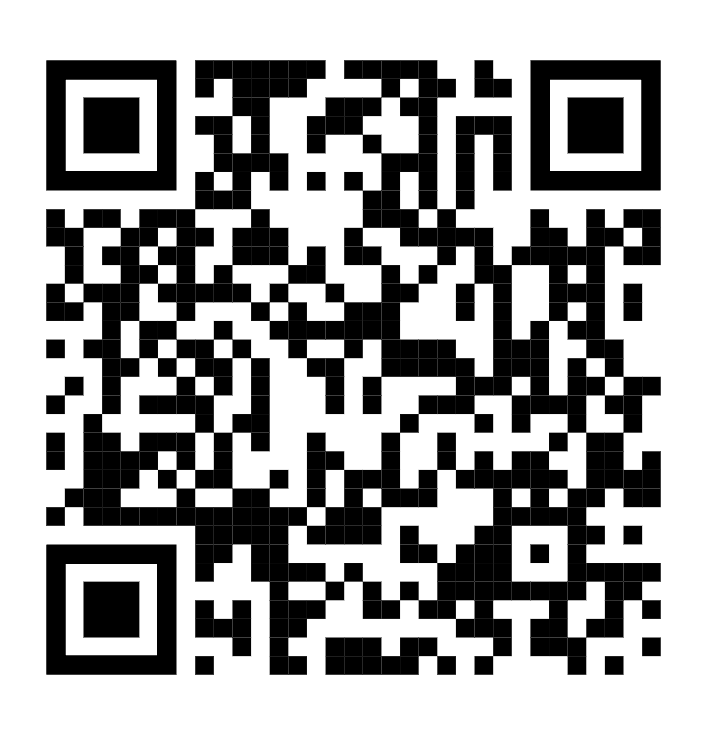